# Определение перспективного тарифа для телеком-компании

Я - аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Для этого мне предоставили данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Тарифы у "Мегалайн" следующие:

**Тариф «Смарт»**
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: 
    1. минута разговора: 3 рубля; 
    2. сообщение: 3 рубля; 
    3. 1 Гб интернет-трафика: 200 рублей.

**Тариф «Ультра»**
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: 
    1. минута разговора: 1 рубль; 
    2. сообщение: 1 рубль; 
    3. 1 Гб интернет-трафика: 150 рублей.
    
**Примечание:** 

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Изучение данных из файлов

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import math
import numpy as np

Согласно инструкции, в нашем распоряжении следующие файлы:

`calls.csv`, `internet.csv`, `messages.csv`, `tariffs.csv`, `users.csv`.

Пройдемся по каждому из них.

### `calls.csv`

Импортируем файл.

In [2]:
calls = pd.read_csv('/datasets/calls.csv')

Посмотрим первые 10 строк.

In [3]:
calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


Посмотрим общую информацию о данных.

In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


В таблице 4 столбца. Типы данных: object, float и int.

Согласно документации, столбцы отражают следующее:

- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

### `internet.csv`

Повторим то же самое для этого файла.

In [6]:
internet = pd.read_csv('/datasets/internet.csv')
internet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [7]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [8]:
internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


В таблице 5 столбцов (при чем первый из них, по всей видимости, лишний). Типы данных: object, float и int.

Согласно документации, столбцы отражают следующее:

- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

### `messages.csv`

Повторим то же самое для этого файла.

In [9]:
messages = pd.read_csv('/datasets/messages.csv')
messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [11]:
messages.describe()

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


В таблице 3 столбца. Типы данных: object, int.

Согласно документации, столбцы отражают следующее:
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

### `tariffs.csv`

Повторим то же самое для этого файла.

In [12]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.head(10)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [13]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


В столбце 8 столбцов. Типы данных: object, int.

Согласно документации, столбцы отражают следующее:
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### `users.csv`

Повторим то же самое для этого файла.

In [14]:
users = pd.read_csv('/datasets/users.csv')
users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [16]:
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


В столбце 8 столбцов. Типы данных: object, int.

Согласно документации, столбцы отражают следующее:
- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tariff` — название тарифного плана

**Вывод**

В данном пункте:
- Было проведено ознакомление с данными. 
- По каждому файлу было описано, что означают те или иные столбцы.

## Подготовка данных

### Смена типов данных

Для всех датасетов необходимо привести дату в формат datetime, что в дальнейшем облегчит работу с данными столбцами.

In [17]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

### Проверка данных на ошибки

В качестве "ошибок" можно выделить лишний столбец в файле `internet`, который можно удалить.

In [18]:
internet.drop(internet.columns[0],axis=1,inplace=True)

Также в датасетах присутствуют нулевые значения звонков и переданного интернет-трафика.

Согласно исходным данным, нулевые значения продолжительности звонков - входящие звонки. 

При этом о причинах нулевого трафика за интернет-сессию говорить сложно. Проверим количество таких строк.

In [19]:
internet.query('mb_used == 0').shape[0]

19598

Таких строк всего около 20 тысяч. Напомним, что всего в датасете порядка 150 тысяч значений. Можно предположить, что за 0 засчитывались случаи, когда у абонента был включен интернет, но не было никакого обмена данными. На расчеты это нам повлиять не должно, так как мы будем считать количество потраченных мегабайт.

### Расчет активности каждого пользователя по месяцам

#### Количество сделанных звонков и израсходованных минут

Для начала добавим столбец с месяцем для каждой строки в датасете и выведем первые 5 строк на экран.

In [20]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls.head(5)

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12


Теперь создадим сводную таблицу по исходящим звонкам (то есть длительностью больше 0 мин). Посчитаем для каждого пользователя количество и сумму исходящих звонков для каждого месяца. 

Выведем первые 5 строк на экран.

In [21]:
user_calls = (pd.
              pivot_table(calls.query('duration > 0'),
                          index=['user_id','month'],
                          values='duration',
                          aggfunc=['sum','count'])
             )
user_calls.head(5)

sum    count
              duration duration
user_id month                  
1000    5       150.06       17
        6       158.90       28
        7       318.80       41
        8       389.87       42
        9       440.14       46

#### Количество отправленных сообщений

Проделаем то же самое для отправленных сообщений.

Добавим столбец с месяцем.

In [22]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


Создаем сводную таблицу и выводим первые 10 строк на экран.

In [23]:
user_messages = (pd.
                 pivot_table(messages,
                             index=['user_id', 'month'],
                             values='message_date',
                             aggfunc='count')
                )
user_messages.head()

message_date
user_id month              
1000    5                22
        6                60
        7                75
        8                81
        9                57

#### Объем израсходанного интернет-трафика

Проделаем то же самое для интернет-трафика.

Добавим столбец с месяцем.

In [24]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


Создадим сводную таблицу и выведем первые 10 строк на экран.

In [25]:
user_internet = (pd.
                 pivot_table(internet,
                            index=['user_id', 'month'],
                            values='mb_used',
                            aggfunc='sum')
                )
user_internet.head()

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91

#### Выручка с каждого абонента

Соединим все три таблицы по каждому пользователю и выведем первые 5 строк на экран.

In [26]:
user_usage = (pd.
              merge(user_calls, user_messages, on=['user_id','month'], how='outer').
              merge(user_internet, on=['user_id','month'], how='outer')
             )
user_usage.head(5)

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


(sum, duration)  (count, duration)  message_date   mb_used
user_id month                                                            
1000    5               150.06               17.0          22.0   2253.49
        6               158.90               28.0          60.0  23233.77
        7               318.80               41.0          75.0  14003.64
        8               389.87               42.0          81.0  14055.93
        9               440.14               46.0          57.0  14568.91

Переименуем столбцы для удобства и выведем первые 5 строк на экран.

In [27]:
columns_new = ['call_duration', 'call_count', 'messages', 'internet']

for i in range(4):
    user_usage = user_usage.rename(columns={user_usage.columns[i]:columns_new[i]})
user_usage.head()

call_duration  call_count  messages  internet
user_id month                                               
1000    5             150.06        17.0      22.0   2253.49
        6             158.90        28.0      60.0  23233.77
        7             318.80        41.0      75.0  14003.64
        8             389.87        42.0      81.0  14055.93
        9             440.14        46.0      57.0  14568.91

Уберем мульти-индекс, созданный сводной таблицей для того, чтобы в дальнейшем в каждой строке прописать тариф пользователя. Выведем первые 10 строк на экран.

In [28]:
user_usage.reset_index(level=1,inplace=True)
user_usage.head()

,month,call_duration,call_count,messages,internet
user_id,,,,,
1000,5,150.06,17.0,22.0,2253.49
1000,6,158.90,28.0,60.0,23233.77
1000,7,318.80,41.0,75.0,14003.64
1000,8,389.87,42.0,81.0,14055.93
1000,9,440.14,46.0,57.0,14568.91


Добавим столбец с тарифом пользователя.

In [29]:
user_usage = pd.merge(user_usage, users[['user_id','tariff']], on=['user_id'], how='outer')
user_usage.head()

,user_id,month,call_duration,call_count,messages,internet,tariff
0,1000,5.0,150.06,17.0,22.0,2253.49,ultra
1,1000,6.0,158.90,28.0,60.0,23233.77,ultra
2,1000,7.0,318.80,41.0,75.0,14003.64,ultra
3,1000,8.0,389.87,42.0,81.0,14055.93,ultra
4,1000,9.0,440.14,46.0,57.0,14568.91,ultra


Посчитаем выручку с каждого пользователя.

Добавим новый столбец и присвоим для начала всем строкам значение 0.

Далее в зависимости от тарифа будем рассчитывать, сколько абонент заплатил в каждый месяц. После вычислений выведем первые 10 строк на экран.

In [30]:
user_usage['revenue'] = 0
for i in range(len(user_usage['user_id'])):
    value = 0
    if user_usage['tariff'][i] == tariffs['tariff_name'][0]:
        value += tariffs['rub_monthly_fee'][0]
        if user_usage['call_duration'][i] > tariffs['minutes_included'][0]:
            value += (user_usage['call_duration'][i] - tariffs['minutes_included'][0])*tariffs['rub_per_minute'][0]
        if user_usage['messages'][i] > tariffs['messages_included'][0]:
            value += (user_usage['messages'][i] - tariffs['messages_included'][0])*tariffs['rub_per_message'][0]
        if user_usage['internet'][i] > tariffs['mb_per_month_included'][0]:
            value += math.ceil((user_usage['internet'][i] - tariffs['mb_per_month_included'][0])/1000)*tariffs['rub_per_gb'][0]
        user_usage['revenue'][i] = value
    if user_usage['tariff'][i] == tariffs['tariff_name'][1]:
        value += tariffs['rub_monthly_fee'][1]
        if user_usage['call_duration'][i] > tariffs['minutes_included'][1]:
            value += (user_usage['call_duration'][i] - tariffs['minutes_included'][1])*tariffs['rub_per_minute'][1]
        if user_usage['messages'][i] > tariffs['messages_included'][1]:
            value += (user_usage['messages'][i] - tariffs['messages_included'][1])*tariffs['rub_per_message'][1]
        if user_usage['internet'][i] > tariffs['mb_per_month_included'][1]:
            value += math.ceil((user_usage['internet'][i] - tariffs['mb_per_month_included'][1])/1000)*tariffs['rub_per_gb'][1]
        user_usage['revenue'][i] = value
user_usage.head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,user_id,month,call_duration,call_count,messages,internet,tariff,revenue
0,1000,5.0,150.06,17.0,22.0,2253.49,ultra,1950
1,1000,6.0,158.90,28.0,60.0,23233.77,ultra,1950
2,1000,7.0,318.80,41.0,75.0,14003.64,ultra,1950
3,1000,8.0,389.87,42.0,81.0,14055.93,ultra,1950
4,1000,9.0,440.14,46.0,57.0,14568.91,ultra,1950
5,1000,10.0,328.45,44.0,73.0,14702.49,ultra,1950
6,1000,11.0,319.04,37.0,58.0,14756.47,ultra,1950
7,1000,12.0,312.98,38.0,70.0,9817.61,ultra,1950
8,1001,11.0,408.12,45.0,NaN,18429.34,smart,1350
9,1001,12.0,391.34,47.0,NaN,14036.66,smart,550


**Вывод**

В данном пункте:
- Было рассчитано, сколько каждый пользователь потратил минут, сообщений и интернет-трафика в разные месяцы.
- Посчитана выручка с каждого абонента.

## Анализ данных

### Тариф smart

Создадим отдельный датасет с использованием трафика пользователями тарифа smart. Выведем значения на экран.

In [31]:
smart_usage = user_usage.query('tariff == "smart"')
smart_usage.head()

,user_id,month,call_duration,call_count,messages,internet,tariff,revenue
8,1001,11.0,408.12,45.0,NaN,18429.34,smart,1350
9,1001,12.0,391.34,47.0,NaN,14036.66,smart,550
10,1002,6.0,110.37,14.0,4.0,10856.82,smart,550
11,1002,7.0,204.75,21.0,11.0,17580.10,smart,1150
12,1002,8.0,269.71,37.0,13.0,20319.26,smart,1550


Проведем расчеты отдельно для каждого вида трафика.

#### Звонки

Создадим сводную таблицу по среднему значению длительности звонков пользователей.

In [32]:
smart_calls = (pd.
 pivot_table(smart_usage,
            index='user_id',
            values='call_duration',
            aggfunc='mean')
)

Построим гистограмму.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe69c95f3d0>]],
      dtype=object)

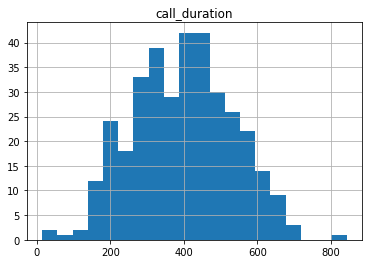

In [33]:
smart_calls.hist(bins=20)

Посчитаем среднее значение.

In [34]:
np.mean(smart_calls)

call_duration    397.210606
dtype: float64

Посчитаем медиану.

In [35]:
np.median(smart_calls)

400.83000000000004

Посчитаем дисперсию.

In [36]:
np.var(smart_calls)

call_duration    18317.648163
dtype: float64

Посчитаем стандартное отклонение.

In [37]:
np.std(smart_calls)

call_duration    135.342706
dtype: float64

**Вывод**

На полученной гистограмме и посчитанным статистическим значениям видно, что распределение длительности потраченных минут абонентами тарифа "Smart" близко к нормальному, со средним значением 397 мин и стандартным отклонением 135 мин.

Можно сказать, что пользователи тарифа "Smart" разговаривают в среднем 397 мин, при этом одинаковое количество пользователей разговаривает больше и меньше среднего. 

Напомним, что в тариф включено 500 мин, то есть в среднем люди не наговаривают больше включенного в тариф количества минут. 

#### Сообщения

Создадим сводную таблицу по среднему количеству отправленных сообщений пользователями.

In [38]:
smart_messages = (pd.
 pivot_table(smart_usage,
            index='user_id',
            values='messages',
            aggfunc='mean')
)

Построим гистограмму.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe69c815fd0>]],
      dtype=object)

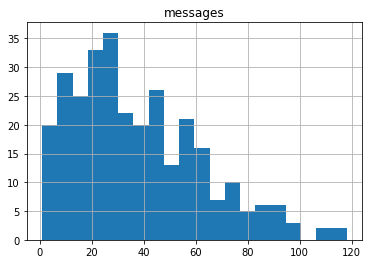

In [39]:
smart_messages.hist(bins=20)

Посчитаем среднее значение.

In [40]:
np.mean(smart_messages)

messages    37.575606
dtype: float64

Посчитаем медиану.

In [41]:
np.median(smart_messages)

33.0

Посчитаем дисперсию.

In [42]:
np.var(smart_messages)

messages    615.464763
dtype: float64

Посчитаем стандартное отклонение.

In [43]:
np.std(smart_messages)

messages    24.808562
dtype: float64

**Вывод**

На полученной гистограмме и посчитанным статистическим значениям видно, что распределение скошено вправо, со средним значением 37 сообщений и стандартным отклонением 25 сообщений.

В данном случае можно сказать, что среди пользователей тарифа "Smart" есть большое количество людей, которые отправляют больше сообщений, чем отправляют в среднем пользователи тарифа.

В тариф включено 50 бесплатных сообщений, то есть в среднем пользователи отправляют меньше включенного в тариф количества сообщений.

#### Интернет

Создадим сводную таблицу по среднему количеству использованного интернет-трафика пользователями.

In [44]:
smart_internet = (pd.
 pivot_table(smart_usage,
            index='user_id',
            values='internet',
            aggfunc='mean')
)

Построим гистограмму.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe69c7524d0>]],
      dtype=object)

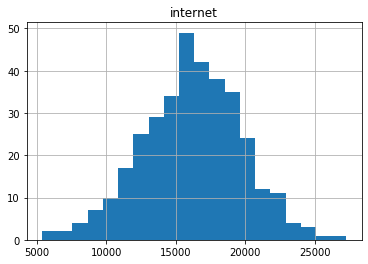

In [45]:
smart_internet.hist(bins=20)

Посчитаем среднее значение.

In [46]:
np.mean(smart_internet)

internet    16190.427408
dtype: float64

Посчитаем медиану.

In [47]:
np.median(smart_internet)

16267.380000000001

Посчитаем дисперсию.

In [48]:
np.var(smart_internet)

internet    1.275991e+07
dtype: float64

Посчитаем стандартное отклонение.

In [49]:
np.std(smart_internet)

internet    3572.10139
dtype: float64

**Вывод**

На полученной гистограмме и посчитанным статистическим значениям видно, что распределение близко к нормальному, но немного скошено влево. Среднее значение и стандартное отклонение составляют 16.2 Гб и 3.6 Гб, соответственно.

Можно сказать, что пользователи тарифа "Smart" тратят в среднем 16.2 Гб интернет-трафика, при этом одинаковое количество пользователей тратит больше и меньше среднего.

Напомним, что в тариф включено 15.4 Гб трафика. Пользователи в среднем используют немного больше трафика, и в последствии переплачивают за дополнительный трафик.

#### Выручка с пользователя

Создадим сводную таблицу по средней выручке с пользователя за месяц.

In [50]:
smart_revenue = (pd.
 pivot_table(smart_usage,
            index='user_id',
            values='revenue',
            aggfunc='mean')
)

Построим гистограмму.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe69b76bc10>]],
      dtype=object)

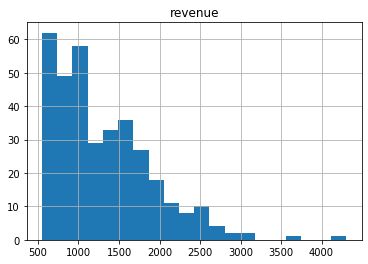

In [51]:
smart_revenue.hist(bins=20)

Посчитаем среднее значение.

In [52]:
np.mean(smart_revenue)

revenue    1300.864112
dtype: float64

Посчитаем медиану.

In [53]:
np.median(smart_revenue)

1151.0

Посчитаем дисперсию.

In [54]:
np.var(smart_revenue)

revenue    362121.516084
dtype: float64

Посчитаем стандартное отклонение.

In [55]:
np.std(smart_revenue)

revenue    601.765333
dtype: float64

**Вывод**

На полученной гистограмме и посчитанным статистическим значениям видно, что распределение скошено вправо. Среднее значение и стандартное отклонение составляют 1300 руб и 600 руб, соответственно.

Видно, что средняя выручка с пользователя выше абонентской платы в 500 руб. 

Поэтому можно сказать, что пользователям данного тарифа не хватает включенных в тариф услуги им приходится переплачивать за связь.

### Тариф ultra

Создадим отдельный датасет с использованием трафика пользователями тарифа ultra. Выведем значения на экран.

In [56]:
ultra_usage = user_usage.query('tariff == "ultra"')
ultra_usage.head()

,user_id,month,call_duration,call_count,messages,internet,tariff,revenue
0,1000,5.0,150.06,17.0,22.0,2253.49,ultra,1950
1,1000,6.0,158.90,28.0,60.0,23233.77,ultra,1950
2,1000,7.0,318.80,41.0,75.0,14003.64,ultra,1950
3,1000,8.0,389.87,42.0,81.0,14055.93,ultra,1950
4,1000,9.0,440.14,46.0,57.0,14568.91,ultra,1950


#### Звонки

Создадим сводную таблицу по среднему значению длительности звонков пользователей.

In [57]:
ultra_calls = (pd.
 pivot_table(ultra_usage,
            index='user_id',
            values='call_duration',
            aggfunc='mean')
)

Построим гистограмму.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe69b6a1ed0>]],
      dtype=object)

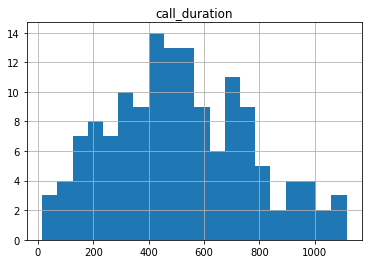

In [58]:
ultra_calls.hist(bins=20)

Посчитаем среднее.

In [59]:
np.mean(ultra_calls)

call_duration    516.383483
dtype: float64

Посчитаем медиану.

In [60]:
np.median(ultra_calls)

497.00625

Посчитаем дисперсию.

In [61]:
np.var(ultra_calls)

call_duration    63495.503184
dtype: float64

Посчитаем стандартное отклонение.

In [62]:
np.std(ultra_calls)

call_duration    251.983141
dtype: float64

**Вывод**

На полученной гистограмме и посчитанным статистическим значениям видно, что распределение длительности потраченных минут абонентами тарифа "Ultra" близко к нормальному, но немного скошено вправо. Среднее значение и стандартное отклонение составляют 516 мин и 252 мин, соответственно.

Напомним, что в тариф включено 3000 мин, то есть в среднем абоненты тарифа "Ultra" наговаривают гораздо меньше включенного в тариф количества минут. 

#### Сообщения

Создадим сводную таблицу по среднему количеству отправленных сообщений пользователями.

In [63]:
ultra_messages = (pd.
 pivot_table(ultra_usage,
            index='user_id',
            values='messages',
            aggfunc='mean')
)

Построим гистограмму.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe69b2b2b10>]],
      dtype=object)

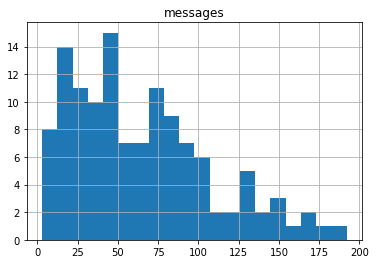

In [64]:
ultra_messages.hist(bins=20)

Посчитаем среднее значение.

In [65]:
np.mean(ultra_messages)

messages    64.555802
dtype: float64

Посчитаем медиану.

In [66]:
np.median(ultra_messages)

57.8

Посчитаем дисперсию.

In [67]:
np.var(ultra_messages)

messages    1867.561788
dtype: float64

Посчитаем стандартное отклонение.

In [68]:
np.std(ultra_messages)

messages    43.215296
dtype: float64

**Вывод**

На полученной гистограмме и посчитанным статистическим значениям видно, что распределение скошено вправо, со средним значением 65 сообщений и стандартным отклонением 43 сообщений.

В тариф включено 1000 бесплатных сообщений, то есть в среднем пользователи отправляют гораздо меньше включенного в тариф количества сообщений.

#### Интернет

Создадим сводную таблицу по среднему количеству использованного интернет-трафика пользователями.

In [69]:
ultra_internet = (pd.
 pivot_table(ultra_usage,
            index='user_id',
            values='internet',
            aggfunc='mean')
)

Построим гистограмму.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe69b6e9c50>]],
      dtype=object)

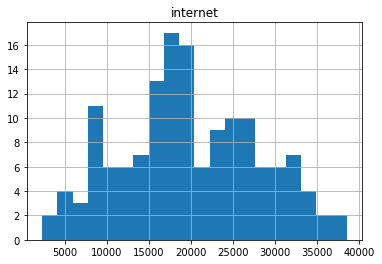

In [70]:
ultra_internet.hist(bins=20)

Посчитаем среднее значение.

In [71]:
np.mean(ultra_internet)

internet    19726.550619
dtype: float64

Посчитаем медиану.

In [72]:
np.median(ultra_internet)

18829.486666666668

Посчитаем дисперсию.

In [73]:
np.var(ultra_internet)

internet    6.630819e+07
dtype: float64

Посчитаем стандартное отклонение.

In [74]:
np.std(ultra_internet)

internet    8142.983995
dtype: float64

**Вывод**

На полученной гистограмме и посчитанным статистическим значениям видно, что немного напоминает нормальное. Среднее значение и стандартное отклонение составляют 19.7 Гб и 8.1 Гб, соответственно.

Напомним, что в тариф включено 30 Гб трафика. Пользователи в среднем используют меньше трафика, чем включено в их тариф.

#### Выручка с пользователя

Создадим сводную таблицу по средней выручке с пользователя за месяц.

In [75]:
ultra_revenue = (pd.
 pivot_table(ultra_usage,
            index='user_id',
            values='revenue',
            aggfunc='mean')
)

Построим гистограмму.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe69a5f2f50>]],
      dtype=object)

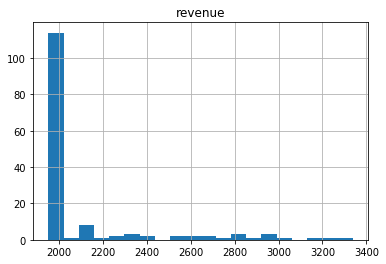

In [76]:
ultra_revenue.hist(bins=20)

Посчитаем среднее значение.

In [77]:
np.mean(ultra_revenue)

revenue    2088.622091
dtype: float64

Посчитаем медиану.

In [78]:
np.median(ultra_revenue)

1950.0

Посчитаем дисперсию.

In [79]:
np.var(ultra_revenue)

revenue    93136.474759
dtype: float64

Посчитаем стандартное отклонение.

In [80]:
np.std(ultra_revenue)

revenue    305.182691
dtype: float64

**Вывод**

На полученной гистограмме и посчитанным статистическим значениям видно, что распределение совсем немного скошено вправо. 

Однако, видно, что выручка с пользователей данного тарифа в основном состоит из абонентской платы за их тариф, которая составляет 1950 руб.

## Проверка гипотиз

### Средняя выручка в зависимости от тарифа

Проверим гипотезу о том, что средние выручки пользователей тарифов "Смарт" и "Ультра" различаются.

В качестве нулевой гипотезы считаем, что выручки одинаковы. В качестве критического уровня статистической значимости примем значение 0.05.

In [81]:
alpha = 0.05
results_1 = st.ttest_ind(smart_revenue, ultra_revenue)

Сравним полученное значение p-value с alpha.

In [82]:
if results_1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, выручки абонентов разных тарифов не одинаковы')
else:
    print("Не получилось отвергнуть нулевую гипотезу, выручки одинаковы") 

Отвергаем нулевую гипотезу, выручки абонентов разных тарифов не одинаковы


**Вывод**

Средние выручки с абонентов разных тарифов не одинаковы.

### Средняя выручка в зависимости от региона

Проверим гипотезу о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. Для начала добавим соответствующий столбец в датасет.

In [83]:
user_usage = pd.merge(user_usage, users[['user_id','city']], on=['user_id'], how='outer')
user_usage.head()

,user_id,month,call_duration,call_count,messages,internet,tariff,revenue,city
0,1000,5.0,150.06,17.0,22.0,2253.49,ultra,1950,Краснодар
1,1000,6.0,158.90,28.0,60.0,23233.77,ultra,1950,Краснодар
2,1000,7.0,318.80,41.0,75.0,14003.64,ultra,1950,Краснодар
3,1000,8.0,389.87,42.0,81.0,14055.93,ultra,1950,Краснодар
4,1000,9.0,440.14,46.0,57.0,14568.91,ultra,1950,Краснодар


Создадим сводные таблицы по среднему значению выручки пользователей Москвы и других регионов.

In [84]:
moscow_revenue = (pd.
 pivot_table(user_usage.query('city == "Москва"'),
            index='user_id',
            values='revenue',
            aggfunc='mean')
)

Построим гистограмму.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe69a52c590>]],
      dtype=object)

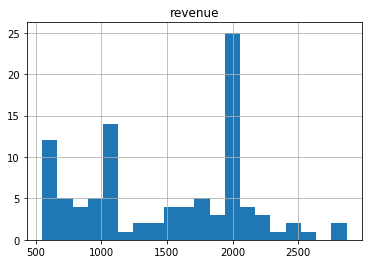

In [85]:
moscow_revenue.hist(bins=20)

In [86]:
nonmoscow_revenue = (pd.
 pivot_table(user_usage.query('city != "Москва"'),
            index='user_id',
            values='revenue',
            aggfunc='mean')
)

Построим гистограмму.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe69a4c29d0>]],
      dtype=object)

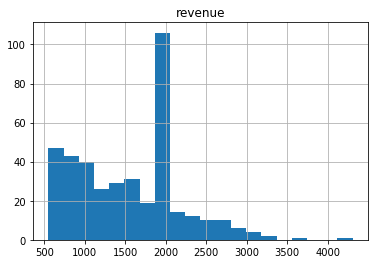

In [87]:
nonmoscow_revenue.hist(bins=20)

В качестве нулевой гипотезы считаем, что выручки одинаковы. В качестве критического уровня статистической значимости примем значение 0.05.

In [88]:
alpha = 0.05
results_2 = st.ttest_ind(moscow_revenue, nonmoscow_revenue)

Сравним полученное значение p-value с alpha.

In [89]:
results_2.pvalue

array([0.3691376])

In [90]:
if results_2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, выручки абонентов Москвы и других регионов не одинаковы')
else:
    print("Не получилось отвергнуть нулевую гипотезу, выручки одинаковы") 

Не получилось отвергнуть нулевую гипотезу, выручки одинаковы


## Общий вывод

В данном проекте были проанализированы данные о том, как абоненты различных тарифов используют включенные в тариф услуги.

1. Было проведено первоначальное знакомство со всеми датасетами.
2. Проведена подготовка данных:
    - Сменен тип данных в столбце с датой для того, чтобы в дальнейшем облегчить работу с данным столбцом.
    - Данные проверены на ошибки.
    - Расчитана активность пользователей, а именно, количество сделанных звонков, отправленных сообщений, израсходанного интернет-трафика и выручки с каждого абонента.
3. Проведен анализ данных:
    - Было показано, что абоненты тарифа "Smart" в среднем используют меньшее количество услуг, чем включено в их тариф. Однако, интернет-трафик в среднем у этих абонентов больше включенного в тариф. Это приводит к тому, что абоненты данного тарифа тратят в среднем больше, чем абонентскую плату. 
    - Для абонентов тарифа "Ultra" наблюдается противоположная картина. Они тратят сильно меньше включенных в их тариф услуг. Поэтому в среднем выручка с этих пользователей составляет только их абонентскую плату.
4. Были проверены следующие гипотезы:
    - "Средняя выручка абонентов разных тарифов одинакова". Однако, данная гипотеза была отвергнута. Это также было видно по построенным гистограммам для выручки абонентов разных тарифов. В среднем абоненты тарифа "Smart" тратили 1300 руб, а абоненты тарифа "Ultra" тратили их абонентскую плату в 1950 руб.
    - "Средняя выручка с абонентов Москвы и других регионов одинакова". Данная гипотеза не была отвергнута. Это говорит о том, что выручка с пользователя не зависит от того, пользуется он услугами в Москве или нет.